In [1]:
from models.training import Trainer
from models.advanced_model import WMF
from data.data_transforming import IDEncoder
from evaluation.evaluator import Evaluator
import numpy as np
import pandas as pd
import torch

In [2]:
sessions_train_df = pd.read_json('data_files/train_sessions.jsonl', lines=True)
sessions_val_df = pd.read_json('data_files/val_sessions.jsonl', lines=True)
users_df = pd.read_json('data_files/users.jsonl', lines=True)
tracks_df = pd.read_json('data_files/tracks.jsonl', lines=True)
user_encoder = IDEncoder()
track_encoder = IDEncoder()
unique_users_count = len(users_df)
unique_tracks_count = len(tracks_df)

In [3]:
user_encoder.fit(users_df["user_id"].unique().tolist())
track_encoder.fit(tracks_df["id"].unique().tolist())

In [4]:
sessions_train_df["user_id"] = user_encoder.encode(sessions_train_df["user_id"].tolist())
sessions_train_df["track_id"] = track_encoder.encode(sessions_train_df["track_id"].tolist())
sessions_val_df["user_id"] = user_encoder.encode(sessions_val_df["user_id"].tolist())
sessions_val_df["track_id"] = track_encoder.encode(sessions_val_df["track_id"].tolist())

In [ ]:
users_range = np.arange(500, 1000)
tracks_range = np.arange(unique_tracks_count)
df = pd.DataFrame(
    product(users_range, tracks_range),
    columns=['user_id', 'track_id']
)

sessions_train_df = df.merge(
    sessions_train_df[['user_id', 'track_id', 'score']],
    on=['user_id', 'track_id'],
    how='left'
).fillna(0)

sessions_val_df = df.merge(
    sessions_val_df[['user_id', 'track_id', 'score']],
    on=['user_id', 'track_id'], 
    how='left'
).fillna(0)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
sessions_train_df['preference'] = sessions_train_df['score'] >= 1
sessions_val_df['preference'] = sessions_val_df['score'] >= 1

In [ ]:
alpha = 40
epsilon = 1e-8
sessions_train_df['weight'] = 1 + alpha * np.log(1 + sessions_train_df['score'] / epsilon)
sessions_val_df['weight'] = 1 + alpha * np.log(1 + sessions_val_df['score'] / epsilon)

In [8]:
sessions_train_df = pd.read_json('data_files/train_sessions.jsonl', lines=True)
tracks_df = pd.read_json('data_files/tracks.jsonl', lines=True)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

dataset = torch.utils.data.TensorDataset(
    torch.LongTensor(sessions_train_df['user_id'].values).to(device),
    torch.LongTensor(sessions_train_df['track_id'].values).to(device),
    torch.FloatTensor(sessions_train_df['score'].values).to(device)
)

train_loader = torch.utils.data.DataLoader(
    dataset,
    batch_size=128,
    shuffle=True
)

unique_users_count = sessions_train_df['user_id'].nunique()
unique_tracks_count = len(tracks_df)

In [9]:
model = WMF(unique_users_count, unique_tracks_count, embedding_dim=32, dropout_rate=0.0, init=True, bias=False, sigmoid=False)

In [10]:
trainer = GMFTrainer(gmf, train_loader, device)
trainer.train_with_weight_decay(
    epochs=3,
    learning_rate=0.01,
    weight_decay=0.15
)

Epoch: 0; Train loss: 3.3565260691364602; Val loss: 0.8299447036914515
Epoch: 1; Train loss: 1.8228102697652424; Val loss: 0.764258630697372
Epoch: 2; Train loss: 1.7380615594150182; Val loss: 0.7508011200510308
Epoch: 3; Train loss: 1.7123505833183053; Val loss: 0.7388890298553525
Epoch: 4; Train loss: 1.6867995200701769; Val loss: 0.7410504471475289
Epoch: 5; Train loss: 1.6928227810025644; Val loss: 0.7399926445027862


KeyboardInterrupt: 

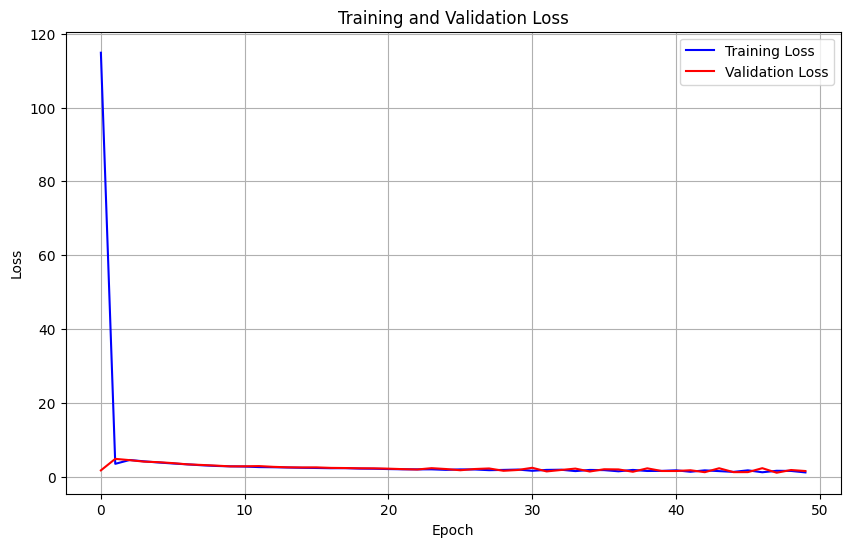

In [8]:
plt.figure(figsize=(10, 6))
plt.plot(train_loss, 'b-', label='Training Loss')
plt.plot(val_loss, 'r-', label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
checkpoint = {
    'model_state_dict': model.state_dict(),
    'model_config': {
        'embedding_dim': model.user_embedding.embedding_dim,
        'dropout_rate': model.dropout.p,
        'bias': model.bias,
        'sigmoid': model.sigmoid,
    },
    'user_encoder': user_encoder,
    'track_encoder': track_encoder
}

torch.save(checkpoint, './model_files/wmf_model.pth')

In [10]:
user_norms = torch.norm(gmf.user_embedding.weight, dim=1)
avg_user_norm = torch.mean(user_norms) 
item_norms = torch.norm(gmf.item_embedding.weight, dim=1)
avg_item_norm = torch.mean(item_norms)

print("Średnia norma user embeddings:", avg_user_norm.item())
print("Średnia norma item embeddings:", avg_item_norm.item())

Średnia norma user embeddings: 0.7438550591468811
Średnia norma item embeddings: 0.3563227951526642


In [6]:
ground_truth_df = pd.read_json('data_files/val_sessions.jsonl', lines=True)
ground_truth_df = ground_truth_df[ground_truth_df['user_id'] < 1000]
all_users = torch.arange(1000).to(device)
all_items = torch.arange(unique_tracks_count).to(device)
all_pairs = torch.cartesian_prod(all_users, all_items)
user_input = all_pairs[:,0]
item_input = all_pairs[:,1]

In [7]:
predictions = []
batch_size = 10000
gmf.eval()
for i in range(0, len(all_pairs), batch_size):
    batch_pairs = all_pairs[i:i + batch_size]
    batch_user_input = batch_pairs[:,0].to(device)
    batch_item_input = batch_pairs[:,1].to(device)
    
    with torch.no_grad():
        batch_predictions = gmf.forward(batch_user_input, batch_item_input)
        predictions.append(batch_predictions)

all_predictions = torch.cat(predictions)

In [8]:
all_pairs_np = all_pairs.cpu().numpy()
all_predictions_np = all_predictions.cpu().numpy()

recommendations_df = pd.DataFrame({
    'user_id': all_pairs_np[:, 0],
    'track_id': all_pairs_np[:, 1],
    'score': all_predictions_np
})

In [9]:
evaluator2 = Evaluator([5, 10, 15, 20, 25], 1.3)

In [10]:
metrics = evaluator2.evaluate(recommendations_df, ground_truth_df)

        user_id  track_id  score_pred  score
0             0        85    0.669505    1.1
1             0       261    0.744107    1.1
2             0       348    0.860759   -0.9
3             0       351    0.171485   -0.9
4             0       407    0.343271    1.1
...         ...       ...         ...    ...
118005      999     11907   -0.169192   -0.9
118006      999     12074    0.904220    0.1
118007      999     12186   -0.301600    0.1
118008      999     12260    0.888139    0.1
118009      999     12284    0.664300    1.1

[118010 rows x 4 columns]


In [11]:
for metric, value in metrics.items():
    print(f'{metric}: {value * 100}%')

Recall@5: 2.0062529340370556%
Recall@5_std: 9.675747534703175%
Precision@5: 4.174265450861196%
Precision@5_std: 13.0065526605638%
Recall@10: 3.4486719941048594%
Recall@10_std: 12.086113833373817%
Precision@10: 4.285714285714286%
Precision@10_std: 12.24212412180259%
Recall@15: 6.077121579969763%
Recall@15_std: 17.456588746134187%
Precision@15: 4.302600472813238%
Precision@15_std: 11.6478386174857%
Recall@20: 8.208738798838093%
Recall@20_std: 20.284300278162135%
Precision@20: 4.366767983789259%
Precision@20_std: 11.42615545086324%
Recall@25: 10.161847397098487%
Recall@25_std: 22.431034610431226%
Precision@25: 4.401215805471124%
Precision@25_std: 11.320211086711257%


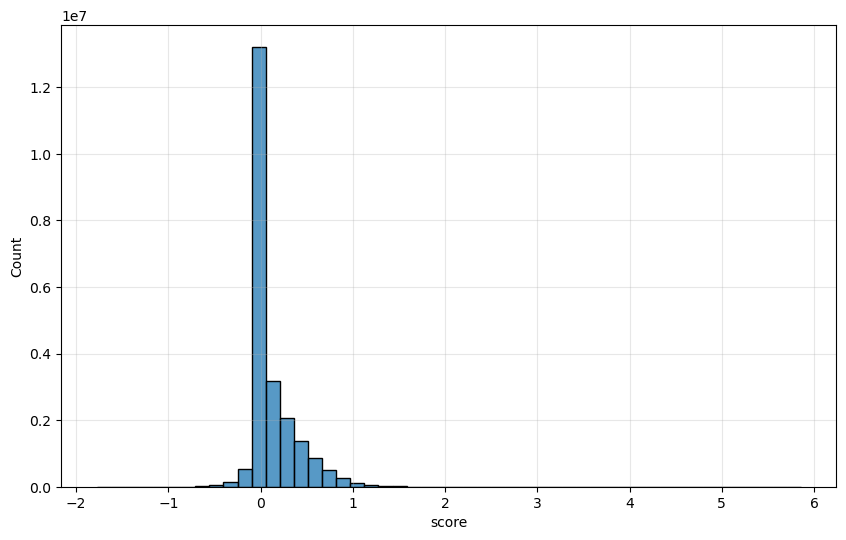

In [12]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
sns.histplot(data=recommendations_df, x='score', bins=50)
plt.grid(True, alpha=0.3)
plt.show()

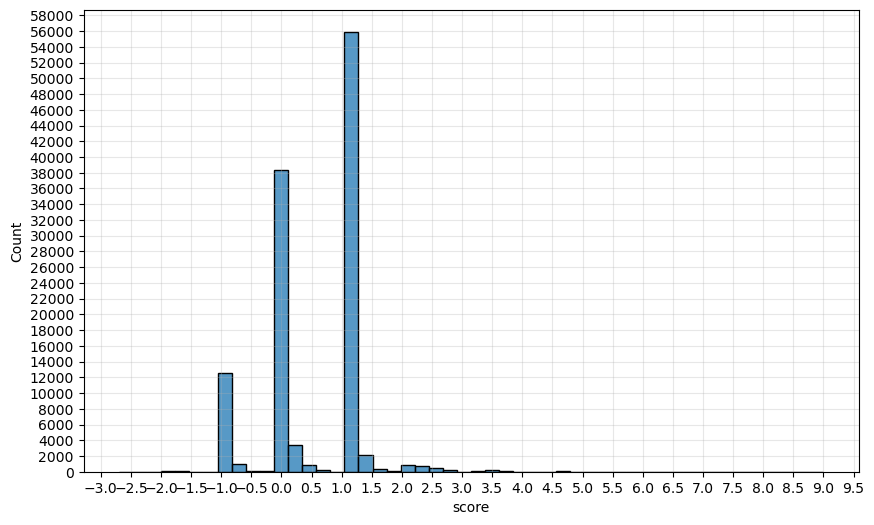

In [13]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
sns.histplot(data=ground_truth_df, x='score', bins=50)
plt.grid(True, alpha=0.3)
plt.gca().xaxis.set_major_locator(plt.MultipleLocator(0.5))
plt.yticks(range(0, 60000, 2000))
plt.show()

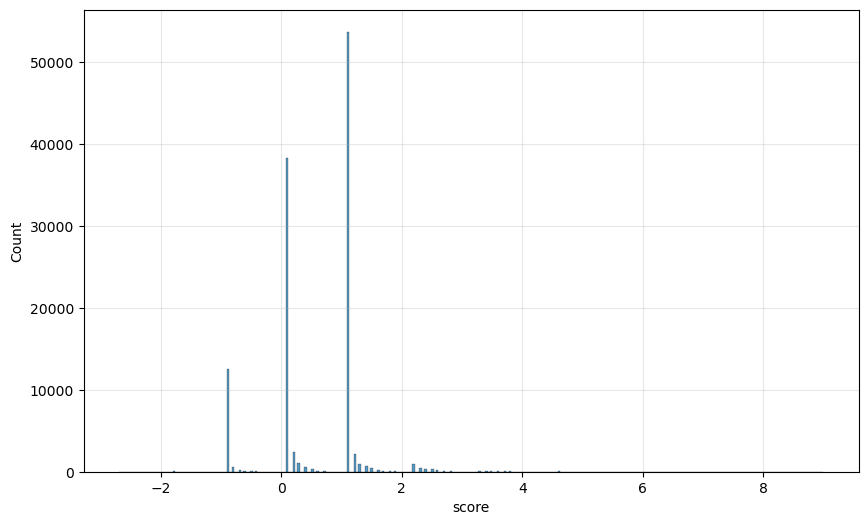

                       score                                
        relevant_items_count total_items relevant_percentage
user_id                                                     
0                          6         204            2.941176
1                          0         216            0.000000
2                          2         187            1.069519
3                          0           3            0.000000
4                          1          38            2.631579
...                      ...         ...                 ...
995                       14          88           15.909091
996                        0          17            0.000000
997                        3         185            1.621622
998                        5         288            1.736111
999                        1         139            0.719424

[987 rows x 3 columns]
relevant_percentage_mean: 4.5444540352276706
relevant_items_mean: 4.523809523809524
total_items_mean: 119.56433637284701


In [15]:
merged_df = recommendations_df.merge(
    ground_truth_df,
    on=['user_id', 'track_id'],
    how='right',
    suffixes=('_pred', '')
).fillna({'score': 0.0})

plt.figure(figsize=(10, 6))
sns.histplot(data=merged_df, x='score', bins=300)
plt.grid(True, alpha=0.3)
plt.show()


relevant_stats = merged_df.groupby('user_id').agg({
    'score': [
        ('relevant_items_count', lambda x: (x > 1.3).sum()),
        ('total_items', 'count'),
        ('relevant_percentage', lambda x: (x > 1.3).mean() * 100)
    ]
})

print(relevant_stats)
print('relevant_percentage_mean: ' + str(relevant_stats[('score', 'relevant_percentage')].mean()))
print('relevant_items_mean: ' + str(relevant_stats[('score', 'relevant_items_count')].mean()))
print('total_items_mean: ' + str(relevant_stats[('score', 'total_items')].mean()))